<a href="https://www.inove.com.ar"><img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/PA%20Banner.png" width="1000" align="center"></a>


# Ejercicio de clasificación con vecinos cercanos (KNN)

Ejemplo de clasificación utilizando vecinos cercanos para la clasificación de drogadas que debería tomar un pasiente según su historial clínico<br>

v1.1

In [ ]:
import os
import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.utils import to_categorical

# Recolectar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline1.png" width="1000" align="middle">

In [ ]:
if os.access('Telecust1.csv', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Telecust1.csv > Telecust1.csv
    else:
        !wget Telecust1.csv https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/Telecust1.csv

### `Telecust1.csv.csv`:
El dataset **`Telecust1.csv.csv`** contiene diferentes tipos de clientes que consumen un servicio de telecomunicación, los cuales deseamos clasificar en 4 categorias.<br> [Dataset source](https://www.kaggle.com/prathamtripathi/customersegmentation)

- **region** --> region, ejemplo 2
- **tenure** --> grado permanencia, ejemplo 40
- **age** --> edad, ejemplo 52
- **income** --> ingresos o sueldo, ejemplo 50 (un número que no representa una moneda real
- **marital** --> si está casado o no
- **address** --> dirección
- **employ** --> empleo
- **retire** --> si está retirado o no
- **genero** --> 0 o 1 (no se sabe cual es cual)


# Procesar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline2.png" width="1000" align="middle">

In [ ]:
df = pd.read_csv("Telecust1.csv")
des = df.describe()
des.loc['Nan'] = df.isna().sum()
des.loc['%Nan'] = (df.isna().mean())*100
des

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,77.535000,0.495000,11.551000,2.671000,10.987000,0.047000,0.517000,2.331000
std,0.8162,21.359812,12.558816,107.044165,0.500225,10.086681,1.222397,10.082087,0.211745,0.499961,1.435793
min,1.0000,1.000000,18.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.0000,17.000000,32.000000,29.000000,0.000000,3.000000,2.000000,3.000000,0.000000,0.000000,1.000000
50%,2.0000,34.000000,40.000000,47.000000,0.000000,9.000000,3.000000,8.000000,0.000000,1.000000,2.000000
75%,3.0000,54.000000,51.000000,83.000000,1.000000,18.000000,4.000000,17.000000,0.000000,1.000000,3.000000
max,3.0000,72.000000,77.000000,1668.000000,1.000000,55.000000,5.000000,47.000000,1.000000,1.000000,8.000000
Nan,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
%Nan,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df.head()

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside,custcat
0,2,13,44,64,1,9,4,5,0,0,2,Basic Service
1,3,11,33,136,1,7,5,5,0,0,6,Total Service
2,3,68,52,116,1,24,1,29,0,1,2,Plus Service
3,2,33,33,33,0,12,2,0,0,1,1,Basic Service
4,2,23,30,30,1,9,1,2,0,0,4,Plus Service


In [ ]:
print('Cantidad de datos en observacion:', df.shape[0])

Cantidad de datos en observacion: 1000


# Explorar datos
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline3.png" width="1000" align="middle">

In [ ]:
df.describe()

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,77.535000,0.495000,11.551000,2.671000,10.987000,0.047000,0.517000,2.331000
std,0.8162,21.359812,12.558816,107.044165,0.500225,10.086681,1.222397,10.082087,0.211745,0.499961,1.435793
min,1.0000,1.000000,18.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.0000,17.000000,32.000000,29.000000,0.000000,3.000000,2.000000,3.000000,0.000000,0.000000,1.000000
50%,2.0000,34.000000,40.000000,47.000000,0.000000,9.000000,3.000000,8.000000,0.000000,1.000000,2.000000
75%,3.0000,54.000000,51.000000,83.000000,1.000000,18.000000,4.000000,17.000000,0.000000,1.000000,3.000000
max,3.0000,72.000000,77.000000,1668.000000,1.000000,55.000000,5.000000,47.000000,1.000000,1.000000,8.000000


In [ ]:
# Exploramos que tan balanceado está el dataset,
# como está repartida las categorias entre los clientes actuales
df['custcat'].value_counts()

Plus Service     281
Basic Service    266
Total Service    236
E-Service        217
Name: custcat, dtype: int64

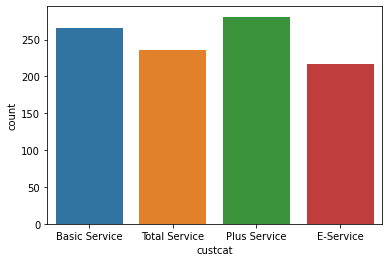

In [ ]:
ax = sns.countplot(data=df, x="custcat")

Se puede ver que el dataset está bastante balanceado, no habrá una tendencia marcada

In [ ]:
# Nos quedamos con aquellas columnas que podemos entender su relacion con el objetivo
df_clean = df[['tenure', 'age', 'income', 'marital', 'retire', 'gender', 'custcat']]
df_clean

,tenure,age,income,marital,retire,gender,custcat
0,13,44,64,1,0,0,Basic Service
1,11,33,136,1,0,0,Total Service
2,68,52,116,1,0,1,Plus Service
3,33,33,33,0,0,1,Basic Service
4,23,30,30,1,0,0,Plus Service
...,...,...,...,...,...,...,...
995,10,39,27,0,0,1,Basic Service
996,7,34,22,0,0,1,Basic Service
997,67,59,944,0,0,1,Total Service
998,70,49,87,0,0,1,Plus Service


#### Normalización de los datos

Analizar cual es la distribución de los datos numéricos
- tenure
- age
- income

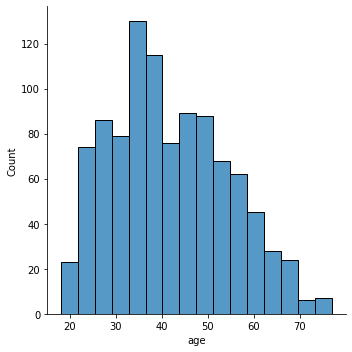

In [ ]:
sns.displot(data=df_clean, x='age')

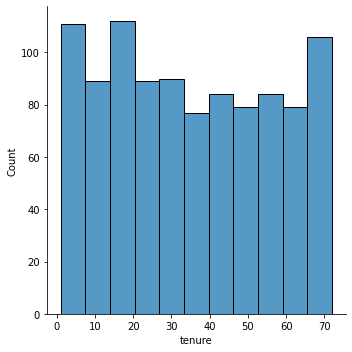

In [ ]:
sns.displot(data=df_clean, x='tenure')

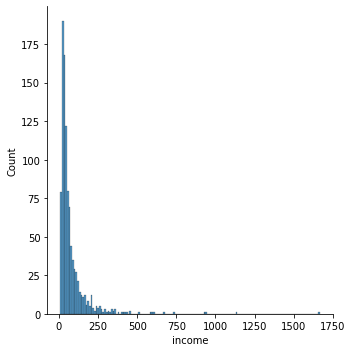

In [ ]:
sns.displot(data=df_clean, x='income')

El "ingreso" sigue una distribución normal pero con muchos outliers, es por eso que no utilizaremos el MinMaxScaler sino que se utilizará el StandardScaler a pesar de que "tenure" no siga una distribución normal

In [ ]:
from sklearn.preprocessing import StandardScaler
df_norm = df_clean.copy()
age_scaler = StandardScaler()
tenure_scaler = StandardScaler()
income_scaler = StandardScaler()
df_norm.loc[:, 'age'] = age_scaler.fit_transform(df[['age']])
df_norm.loc[:, 'tenure'] = tenure_scaler.fit_transform(df[['tenure']])
df_norm.loc[:, 'income'] = income_scaler.fit_transform(df[['income']])
df_norm.head()

,tenure,age,income,marital,retire,gender,custcat
0,-1.055125,0.184505,-0.126506,1,0,0,Basic Service
1,-1.148806,-0.691812,0.546450,1,0,0,Total Service
2,1.521092,0.821826,0.359517,1,0,1,Plus Service
3,-0.118319,-0.691812,-0.416251,0,0,1,Basic Service
4,-0.586722,-0.930808,-0.444291,1,0,0,Plus Service


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_enc = df_norm.copy()
# Reemplazar la columna de salida texto a números
df_enc['custcat'] = le.fit_transform(df_enc['custcat'])
# Clases identificados
le.classes_

array(['Basic Service', 'E-Service', 'Plus Service', 'Total Service'],
      dtype=object)

# Entrenar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline4.png" width="1000" align="middle">

El primer paso es obtener los datos que serán la entrada del sistema (X) y los datos que serán la salida del modelo estimador (y)

In [ ]:
X = df_enc.drop('custcat', axis=1).values
y = to_categorical(df_enc['custcat'])

In [ ]:
in_shape = X.shape[1]
in_shape

6

In [ ]:
out_shape = y.shape[1]
out_shape

4

Siguiente paso es dividir el dataset en entrenamiento (train) y evaluación (test). Utilizaremos el criterio 80%20%

In [ ]:
from sklearn.model_selection import train_test_split
# Fijamos un "random_state" constante para que siempre el dataset se parta de la misma forma
# para poder repetir los ensayos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Crear un modelo de clasificación con vecinos cercanos (KNN)
Parámetros
- n_neighbors --> (k) número de vecinos cercanos

In [ ]:
from keras.layers import Dense

def create_model(hidden_neurons):
    # Crear un modelo secuencial
    model = Sequential()

    # Crear la capa de entrada y la capa oculta (hidden) de la red, que tendrá:
    # --> tantas entradas (input_shape) como columnas (in_shape)
    # --> tantas neuronas como deseemos
    # --> utilizamos "sigmoid" como capa de activación
    model.add(Dense(units=hidden_neurons, activation='sigmoid', input_shape=(in_shape,)))

    # Crear la capa de salida, que tendrá tantas neuronas como salidas posibles
    model.add(Dense(units=out_shape, activation='softmax'))

    return model

In [ ]:


model = create_model(16)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2 , epochs=50, batch_size=32)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 68        
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 [==============================] - 0s 9ms/step - loss: 1.4212 - accuracy: 0.2768 - val_loss: 1.3907 - val_accuracy: 0.2357
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3583 - accuracy: 0.3107 - val_loss: 1.3897 - val_accuracy: 0.2571
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3456 - accuracy: 0.3375 - val_loss: 1.3816 - val_accuracy: 0.2786
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3383 - accuracy: 0.3554

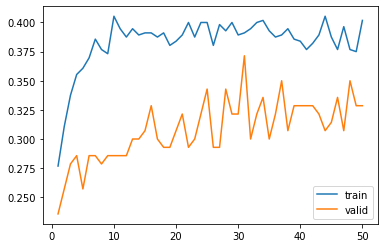

In [ ]:
epoch_count = range(1, len(history.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
y_hat_prob = model.predict(X_test)
y_hat = np.argmax(y_hat_prob,axis=1)

In [ ]:
model.summary()

# Validar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline5.png" width="1000" align="middle">

In [ ]:
# Calcular la exactitud (accuracy)
#scores = model.evaluate(X_test, y_test, verbose=0)
scores = model.evaluate(X_test, y_test)
scores[1]

10/10 [==============================] - 0s 1ms/step - loss: 1.3190 - accuracy: 0.3833


0.38333332538604736

In [ ]:
# Calcular la exactitud (accuracy)
from sklearn.metrics import accuracy_score
accuracy_score(y_test.argmax(axis=1), y_hat, normalize=True)

0.38333333333333336

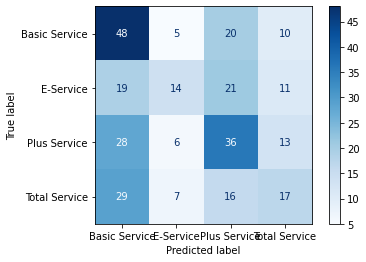

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

# Utilizar modelo
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline6.png" width="1000" align="middle">

In [ ]:
# Supongamos que deseamos ver a que categoría pertenecemos
# dado los siguientes datos
age = 25
tenure = 4
income = df['income'].mean() # ganamos el promedio
marital = 0 # no estamos casados
retire = 0 # no estamos retirados
gender = 1 # solo algun genero

In [ ]:
# El scaler espera como entrada una matriz (filas y columnas)
# Por eso el doble corchete
age_numpy = np.array([[age]])
# Utilizamos float para convertir la matriz que retorna el scaler
# a un número
age_norm = float(age_scaler.transform(age_numpy))
tenure_norm = float(tenure_scaler.transform(np.array([[tenure]])))
income_norm = float(tenure_scaler.transform(np.array([[income]])))
# El sistema espera como entrada "X" en este caso una sola fila pero varias
# columnas, por eso el reshape(1, -1) donde el "-1" significa "varias"
# (el sistema determina cuantas)
X_prueba = np.array([age_norm, tenure_norm, income_norm, marital, retire, gender]).reshape(1, -1)
print('Shape:', X_prueba.shape)
print('Valores:\n', X_prueba)

Shape: (1, 6)
Valores:
 [[-1.32913388 -1.47668785  1.9677149   0.          0.          1.        ]]


In [ ]:
mi_categoria_probabilidades = model.predict(X_prueba)
mi_categoria_probabilidades

array([[0.18948598, 0.08112056, 0.16737081, 0.5620227 ]], dtype=float32)

In [ ]:
mi_categoria_dict = dict(zip(le.classes_, mi_categoria_probabilidades.flatten()))
mi_categoria_dict

{'Basic Service': 0.18948598,
 'E-Service': 0.08112056,
 'Plus Service': 0.16737081,
 'Total Service': 0.5620227}

In [ ]:
mi_categoria_ordenadas = sorted(mi_categoria_dict.items(), key=lambda x: x[1], reverse=True)
for categoria in mi_categoria_ordenadas:
    print(f'Grado de pertenencia a la categoria {categoria[0]}: {categoria[1]*100:.1f}%')

Grado de pertenencia a la categoria Total Service: 56.2%
Grado de pertenencia a la categoria Basic Service: 18.9%
Grado de pertenencia a la categoria Plus Service: 16.7%
Grado de pertenencia a la categoria E-Service: 8.1%


In [ ]:
category = le.inverse_transform((mi_categoria_probabilidades.argmax(),))
category

array(['Total Service'], dtype=object)

In [ ]:
category[0]

'Total Service'

# Conclusión
<img src="https://raw.githubusercontent.com/InoveAlumnos/dataset_analytics_python/master/images/Pipeline7.png" width="1000" align="middle">

En este ejemplo se obtuvo muy poca performance, pero se obtuvo un mejor resultado que la vez que se aplicado el algoritmo de clasificación KNN en donde el accuracy obtenido fue del 34%